In [ ]:
# !pip install nltk gensim wordcloud scikit-learn matplotlib seaborn


In [ ]:
# pip install --force-reinstall --no-cache-dir pandas matplotlib seaborn scikit-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tokenize import word_tokenize

In [2]:
# Cell 3: Import and download nltk resources
import nltk

# Download with explicit download path and verification
import os
nltk_data_path = '/root/nltk_data'
os.makedirs(nltk_data_path, exist_ok=True)

print("Downloading NLTK resources...")
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('wordnet', download_dir=nltk_data_path)

# Verify downloads
for resource in ['punkt', 'stopwords', 'wordnet']:
    try:
        nltk.data.find(f'tokenizers/{resource}') if resource == 'punkt' else nltk.data.find(f'corpora/{resource}')
        print(f"✓ {resource} successfully downloaded")
    except LookupError:
        print(f"✗ {resource} not found - trying to download again")
        nltk.download(resource, quiet=False, download_dir=nltk_data_path)

# Import NLTK modules
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


✓ punkt successfully downloaded
✓ stopwords successfully downloaded
✗ wordnet not found - trying to download again


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Cell 4: Set random seed and visualization styles
import random
random.seed(42)
np.random.seed(42)

# Set up matplotlib for better visualizations
plt.style.use('ggplot')
sns.set(style='whitegrid')

In [4]:
try:
    train_data = pd.read_csv(f'/content/train.csv')
    print("Successfully loaded training data")
except FileNotFoundError:
    print("Training data file not found. Please upload the 'train.csv' file to your Colab environment.")
    from google.colab import files
    uploaded = files.upload()
    train_data = pd.read_csv('train.csv')


Training data file not found. Please upload the 'train.csv' file to your Colab environment.


Saving train.csv to train.csv


# **Pre-Processing**


Basic Cleaning of text

In [5]:
def clean_text(text):
    """
    Clean the text by:
    1. Converting to lowercase
    2. Removing URLs
    3. Removing user mentions (@user)
    4. Removing hashtags
    5. Removing non-alphanumeric characters
    """
    # Convert to string if not already
    text = str(text)

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove user mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (keeping the content without #)
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove non-alphanumeric characters (keeping spaces)
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [6]:
print("Applying basic text cleaning...")
train_data['cleaned_text'] = train_data['text'].apply(clean_text)


Applying basic text cleaning...


Tokenization

instead of the simple tokenization, the text.split. We can still fget back to that if it works better in the model. For now I Made text from the original Pre-Processing. So people can choose to use this pipeline of pre-processing, or use the old pre-processing. To get the old. "cmmnd / " the tokenization below and "de-cmnd /" the old pre-processing steps.

In [7]:
from nltk.tokenize import wordpunct_tokenize

def tokenize_text(text):
    """
    Tokenize using NLTK's wordpunct_tokenize (no download needed).
    """
    return wordpunct_tokenize(text)

train_data['tokens'] = train_data['cleaned_text'].apply(tokenize_text)

In [8]:
train_data[['cleaned_text', 'tokens']].head(5)

,cleaned_text,tokens
0,bynd jpmorgan reels in expectations on beyond ...,"[bynd, jpmorgan, reels, in, expectations, on, ..."
1,ccl rcl nomura points to bookings weakness at ...,"[ccl, rcl, nomura, points, to, bookings, weakn..."
2,cx cemex cut at credit suisse jp morgan on wea...,"[cx, cemex, cut, at, credit, suisse, jp, morga..."
3,ess btig research cuts to neutral,"[ess, btig, research, cuts, to, neutral]"
4,fnko funko slides after piper jaffray pt cut,"[fnko, funko, slides, after, piper, jaffray, p..."


Stop word removal

In [ ]:
# #Define stopword removal function
# def remove_stopwords(text, stop_words=None):
#     """Remove stopwords from text"""
#     if stop_words is None:
#         stop_words = set(stopwords.words('english'))

#     # Use simple split instead of word_tokenize
#     word_tokens = text.split()
#     filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
#     return ' '.join(filtered_text)

In [ ]:
# # Apply stopword removal
# print("Removing stopwords...")
# train_data['text_no_stopwords'] = train_data['cleaned_text'].apply(remove_stopwords)


In [9]:
# Define stopword removal function for token lists
def remove_stopwords_from_tokens(tokens, stop_words=None):
    """Remove stopwords from a list of tokens"""
    if stop_words is None:
        stop_words = set(stopwords.words('english'))

    return [word for word in tokens if word.lower() not in stop_words]

# Apply to tokenized column
print("Removing stopwords...")
train_data['filtered_tokens'] = train_data['tokens'].apply(remove_stopwords_from_tokens)

Removing stopwords...


### Wether we use Stemming or Lemmatization, it matters:
Yes, order matters — and here’s the correct order to follow:

Text cleaning (✅ you've done this already)

Stopword removal

(EITHER) Lemmatization OR Stemming ← choose one

You're currently doing both — that’s fine for testing, but for your final model, you should pick:

Lemmatization if you're using ML with semantic features (TF-IDF, embeddings)

Stemming if you’re doing simpler, brute-force BoW models

Lemmatization

In [ ]:
# # Define lemmatization function
# def lemmatize_text(text):
#     """Apply lemmatization to text"""
#     lemmatizer = WordNetLemmatizer()
#     # Use simple split instead of word_tokenize
#     word_tokens = text.split()
#     lemmatized_text = [lemmatizer.lemmatize(word) for word in word_tokens]
#     return ' '.join(lemmatized_text)

In [ ]:
# # Apply lemmatization
# print("Applying lemmatization...")
# train_data['lemmatized_text'] = train_data['text_no_stopwords'].apply(lemmatize_text)
# print("Preprocessing complete.")

In [10]:
# Define lemmatization function for token lists
def lemmatize_tokens(tokens):
    """Lemmatize a list of tokens"""
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

# Apply to filtered tokens
print("Applying lemmatization...")
train_data['lemmatized_tokens'] = train_data['filtered_tokens'].apply(lemmatize_tokens)
print("Preprocessing complete.")

Applying lemmatization...
Preprocessing complete.


Stemming

In [ ]:
# # Define stemming function
# def stem_text(text):
#     """Apply stemming to text"""
#     stemmer = SnowballStemmer('english')
#     # Use simple split instead of word_tokenize
#     word_tokens = text.split()
#     stemmed_text = [stemmer.stem(word) for word in word_tokens]
#     return ' '.join(stemmed_text)

In [ ]:
# # Apply stemming
# print("Applying stemming...")
# train_data['stemmed_text'] = train_data['text_no_stopwords'].apply(stem_text)


In [11]:
# Define stemming function for token lists
def stem_tokens(tokens):
    """Apply stemming to a list of tokens"""
    stemmer = SnowballStemmer('english')
    return [stemmer.stem(word) for word in tokens]

# Apply to filtered tokens
print("Applying stemming...")
train_data['stemmed_tokens'] = train_data['filtered_tokens'].apply(stem_tokens)

Applying stemming...


### Sanity check/pre-processing check

In [ ]:
# sample_indices = random.sample(range(len(train_data)), 3)
# for idx in sample_indices:
#     print(f"Original: {train_data.loc[idx, 'text']}")
#     print(f"Cleaned: {train_data.loc[idx, 'cleaned_text']}")
#     print(f"No Stopwords: {train_data.loc[idx, 'text_no_stopwords']}")
#     print(f"Stemmed: {train_data.loc[idx, 'stemmed_text']}")
#     print(f"Lemmatized: {train_data.loc[idx, 'lemmatized_text']}")
#     print("-" * 100)


In [12]:
# Sample 3 random rows
sample_indices = random.sample(range(len(train_data)), 3)

# Print transformations for each sampled row
for idx in sample_indices:
    print(f"Original: {train_data.loc[idx, 'text']}")
    print(f"Cleaned: {train_data.loc[idx, 'cleaned_text']}")
    print(f"Tokens: {train_data.loc[idx, 'tokens']}")
    print(f"No Stopwords (filtered_tokens): {train_data.loc[idx, 'filtered_tokens']}")
    print(f"Stemmed: {train_data.loc[idx, 'stemmed_tokens']}")
    print(f"Lemmatized: {train_data.loc[idx, 'lemmatized_tokens']}")
    print("_" * 100)

Original: Report: FreightCar America Closing Roanoke Plant
Cleaned: report freightcar america closing roanoke plant
Tokens: ['report', 'freightcar', 'america', 'closing', 'roanoke', 'plant']
No Stopwords (filtered_tokens): ['report', 'freightcar', 'america', 'closing', 'roanoke', 'plant']
Stemmed: ['report', 'freightcar', 'america', 'close', 'roanok', 'plant']
Lemmatized: ['report', 'freightcar', 'america', 'closing', 'roanoke', 'plant']
____________________________________________________________________________________________________
Original: Former Fed chief Bernanke sees bad year, no quick recovery #economy #MarketScreener https://t.co/YaN7qVv5aq https://t.co/zn3oEbjuL7
Cleaned: former fed chief bernanke sees bad year no quick recovery economy marketscreener
Tokens: ['former', 'fed', 'chief', 'bernanke', 'sees', 'bad', 'year', 'no', 'quick', 'recovery', 'economy', 'marketscreener']
No Stopwords (filtered_tokens): ['former', 'fed', 'chief', 'bernanke', 'sees', 'bad', 'year', 'quic

Uni,Bi & Tri-gram check

In [ ]:
# def get_top_ngrams_by_label(data, text_col='lemmatized_text', label_col='label', ngram_range=(1,3), top_n=10):
#     """
#     Get top n-grams (1–3 by default) with counts per sentiment label.
#     Returns a DataFrame with columns: Bearish (0), Bullish (1), Neutral (2)
#     """
#     top_ngrams = {}

#     for sentiment in sorted(data[label_col].unique()):
#         subset = data[data[label_col] == sentiment][text_col]
#         vectorizer = CountVectorizer(ngram_range=ngram_range)
#         X = vectorizer.fit_transform(subset)

#         sum_words = X.sum(axis=0)
#         word_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
#         word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)[:top_n]

#         top_ngrams[sentiment] = [f"{phrase} ({count})" for phrase, count in word_freq]

#     df_top = pd.DataFrame(top_ngrams)
#     df_top.columns = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
#     return df_top

# top_ngrams_post_preprocessing = get_top_ngrams_by_label(train_data, text_col='lemmatized_text', ngram_range=(1, 3), top_n=15)
# display(top_ngrams_post_preprocessing)

In [13]:
def get_top_ngrams_by_label(data, token_col, label_col='label', ngram_range=(1, 3), top_n=10):
    """
    Get the top n-grams per sentiment label from a token-based column.

    Parameters:
    - data: pd.DataFrame
    - token_col: str, name of column containing list of tokens (e.g., 'lemmatized_tokens', 'stemmed_tokens')
    - label_col: str, name of sentiment column (default: 'label')
    - ngram_range: tuple, e.g., (1, 3) for unigrams + bigrams + trigrams
    - top_n: int, number of top phrases to show per class

    Returns:
    - DataFrame with top n-grams per sentiment (columns: label names)
    """
    top_ngrams = {}

    for label in sorted(data[label_col].unique()):
        # Join token lists into text per row
        subset_tokens = data[data[label_col] == label][token_col]
        subset_texts = subset_tokens.apply(lambda tokens: ' '.join(tokens))

        # Create vectorizer and count frequencies
        vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
        X = vectorizer.fit_transform(subset_texts)

        sum_words = X.sum(axis=0)
        word_freq = [(word, int(sum_words[0, idx])) for word, idx in vectorizer.vocabulary_.items()]
        word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)[:top_n]

        top_ngrams[label] = [f"{word} ({count})" for word, count in word_freq]

    # Optional: Rename columns to human-readable labels
    label_names = {0: 'Bearish (0)', 1: 'Bullish (1)', 2: 'Neutral (2)'}
    df_top = pd.DataFrame(top_ngrams)
    df_top.rename(columns=label_names, inplace=True)

    return df_top

Example usage with lemmatized_tokens

In [14]:
top_ngrams_post = get_top_ngrams_by_label(
    train_data,
    token_col='lemmatized_tokens',  # you can also pass 'stemmed_tokens'
    ngram_range=(1, 3),
    top_n=15
)

display(top_ngrams_post)

,Bearish (0),Bullish (1),Neutral (2)
0,stock (211),stock (369),stock (742)
1,miss (105),beat (194),marketscreener (375)
2,market (98),market (166),result (320)
3,cut (97),price (156),report (299)
4,price (93),share (144),new (285)
5,oil (80),target (122),stock marketscreener (282)
6,coronavirus (79),revenue (110),market (274)
7,share (78),price target (106),say (269)
8,china (77),new (97),earnings (256)
9,economy (68),eps (92),2019 (245)


If new pre-processing used, first run cell below. When use old pre-processing don't.

In [15]:
train_data['lemmatized_text'] = train_data['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))

In [16]:
X = train_data['lemmatized_text']  # We'll use lemmatized text for feature engineering
y = train_data['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the split
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Training label distribution: {y_train.value_counts().sort_index().tolist()}")
print(f"Validation label distribution: {y_val.value_counts().sort_index().tolist()}")


Training set size: 7634
Validation set size: 1909
Training label distribution: [1154, 1538, 4942]
Validation label distribution: [288, 385, 1236]


# **Feature Engineering**


In [18]:
# Cell 30: Import necessary libraries for feature engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np

# Try to fix gensim compatibility issue by reinstalling
!pip install --force-reinstall gensim

# Now try importing again
try:
    from gensim.models import Word2Vec
    GENSIM_AVAILABLE = True
except Exception as e:
    print(f"Could not import Word2Vec: {e}")
    print("Will continue without Word2Vec features")
    GENSIM_AVAILABLE = False

print("Starting Feature Engineering...")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: smart-open
    Found existing installation: smart-open 7.1.0
    Uninstalling smart-open-7.1.0:
      Successfully uninstalle

In [19]:
# Cell 31: Bag of Words (BoW) features
print("Creating Bag of Words features...")
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)

print(f"BoW vocabulary size: {len(bow_vectorizer.vocabulary_)}")
print(f"BoW feature matrix shape: {X_train_bow.shape}")

# Display sample features
feature_names = bow_vectorizer.get_feature_names_out()
print("Sample BoW features (first 10):", feature_names[:10])

Creating Bag of Words features...
BoW vocabulary size: 5000
BoW feature matrix shape: (7634, 5000)
Sample BoW features (first 10): ['00' '001' '002' '003' '004' '005' '006' '007' '0075' '008']


Creating TF-IDF features...
TF-IDF vocabulary size: 5000
TF-IDF feature matrix shape: (7634, 5000)


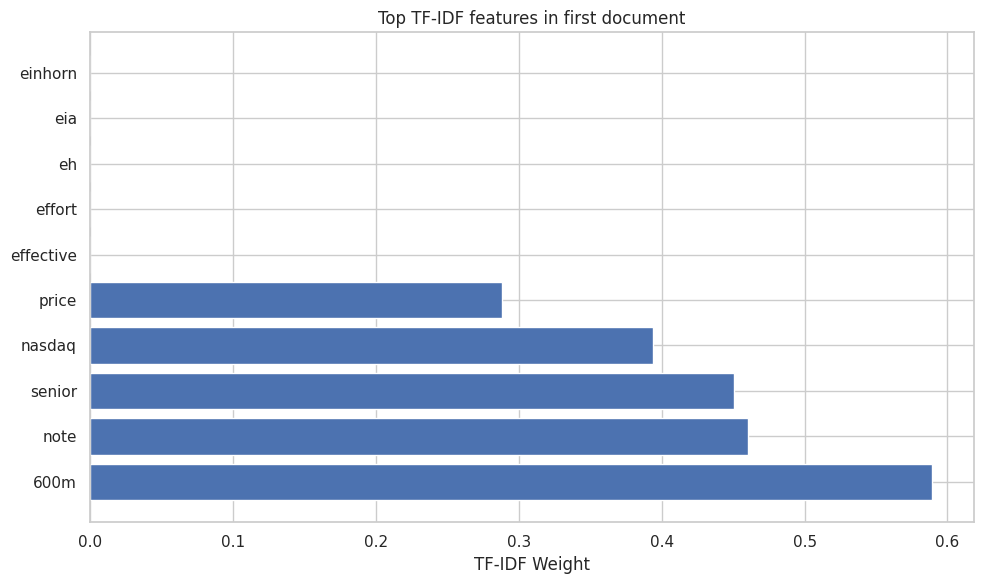

In [20]:
# Cell 32: TF-IDF features
print("Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

print(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

# Visualize TF-IDF importance for first document
first_doc_tfidf = X_train_tfidf[0].toarray()[0]
# Get indices of top features
top_indices = first_doc_tfidf.argsort()[-10:][::-1]
top_features = tfidf_vectorizer.get_feature_names_out()[top_indices]
top_weights = first_doc_tfidf[top_indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features, top_weights)
plt.title('Top TF-IDF features in first document')
plt.xlabel('TF-IDF Weight')
plt.tight_layout()
plt.show()

### Extra Feature Engineering (TF-IDF with N-grams)


In [21]:
# TF-IDF with N-grams (unigrams + bigrams)
print("Creating TF-IDF features with n-grams (unigrams + bigrams)...")
tfidf_ngram_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=8000)
X_train_tfidf_ngram = tfidf_ngram_vectorizer.fit_transform(X_train)
X_val_tfidf_ngram = tfidf_ngram_vectorizer.transform(X_val)

print(f"TF-IDF N-gram vocabulary size: {len(tfidf_ngram_vectorizer.vocabulary_)}")
print(f"TF-IDF N-gram feature matrix shape: {X_train_tfidf_ngram.shape}")

Creating TF-IDF features with n-grams (unigrams + bigrams)...
TF-IDF N-gram vocabulary size: 8000
TF-IDF N-gram feature matrix shape: (7634, 8000)


In [38]:
# Cell 33-37: Word2Vec features (conditional)
# Only run if gensim is available
if GENSIM_AVAILABLE:
    print("Preparing data for Word2Vec...")
    # Function to tokenize text
    def tokenize_texts(texts):
        return [text.split() for text in texts]

    # Tokenize all texts for training
    all_tokenized = tokenize_texts(train_data['cleaned_text'])
    # all_tokenized = tokenize_texts(X_train)

    # Display a sample
    print(f"Sample tokenized text: {all_tokenized[0][:10]}...")

    # Train Word2Vec model
    print("Training Word2Vec model...")
    w2v_model = Word2Vec(
        sentences=all_tokenized,
        vector_size=100,  # Embedding dimension
        window=5,         # Context window size
        min_count=2,      # Ignore words that appear less than this
        workers=4,        # Number of processor cores
        sg=1              # 1 for skip-gram, 0 for CBOW
    )

    print(f"Word2Vec vocabulary size: {len(w2v_model.wv.key_to_index)}")
    print(f"Word2Vec vector dimension: {w2v_model.wv.vector_size}")

    # Create document vectors from Word2Vec
    print("Creating document vectors from Word2Vec...")

    def document_vector(text, model, vector_size=100):
        """
        Create a document vector by averaging word vectors
        for all words in the document
        """
        # Split the text into words
        words = text.split()

        # Initialize an empty array for the document vector
        doc_vector = np.zeros(vector_size)

        # Count valid words
        count = 0

        # Add vectors for each word if it exists in the model
        for word in words:
            if word in model.wv:
                doc_vector += model.wv[word]
                count += 1

        # Return the average vector
        if count > 0:
            return doc_vector / count
        else:
            return doc_vector  # Return zeros if no words found

    # Create document vectors for training and validation sets
    X_train_w2v = np.array([document_vector(text, w2v_model) for text in X_train])
    X_val_w2v = np.array([document_vector(text, w2v_model) for text in X_val])

    print(f"Word2Vec document vectors shape: {X_train_w2v.shape}")
else:
    print("Skipping Word2Vec feature engineering")
    X_train_w2v = None
    X_val_w2v = None

Skipping Word2Vec feature engineering


#### Extra Feature Engineering (Length and structure features)

In [39]:
# Step 1: Create DataFrames from X_train and X_val (text data)
import pandas as pd

train_struct = pd.DataFrame({'cleaned_text': X_train}).copy()
val_struct = pd.DataFrame({'cleaned_text': X_val}).copy()

# Step 2: Define function to extract structural features
def extract_text_features(df, text_column='cleaned_text'):
    df['char_count'] = df[text_column].apply(len)
    df['word_count'] = df[text_column].apply(lambda x: len(x.split()))
    df['avg_word_length'] = df['char_count'] / df['word_count']
    df['punctuation_count'] = df[text_column].apply(lambda x: sum(1 for c in x if c in '.,;!?'))
    df['capital_word_count'] = df[text_column].apply(lambda x: sum(1 for w in x.split() if w.isupper()))
    return df

# Step 3: Extract features
train_struct = extract_text_features(train_struct)
val_struct = extract_text_features(val_struct)

# Step 4: Convert to NumPy arrays
X_train_structural = train_struct[['char_count', 'word_count', 'avg_word_length',
                                   'punctuation_count', 'capital_word_count']].values

X_val_structural = val_struct[['char_count', 'word_count', 'avg_word_length',
                               'punctuation_count', 'capital_word_count']].values

# Step 5: Show result
print("Structural feature shape:", X_train_structural.shape)

Structural feature shape: (7634, 5)


#### Comparing features


In [40]:
# Cell 38: Compare feature engineering methods
print("Summary of Feature Engineering Methods:")
print(f"1. Bag of Words: {X_train_bow.shape[1]} features")
print(f"2. TF-IDF: {X_train_tfidf.shape[1]} features")

if X_train_w2v is not None:
    print(f"3. Word2Vec: {X_train_w2v.shape[1]} features")

    # Compare sparsity
    bow_sparsity = 1.0 - (X_train_bow.nnz / (X_train_bow.shape[0] * X_train_bow.shape[1]))
    tfidf_sparsity = 1.0 - (X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))
    w2v_sparsity = np.count_nonzero(X_train_w2v == 0) / (X_train_w2v.shape[0] * X_train_w2v.shape[1])

    print("\nSparsity (percentage of zero values):")
    print(f"Bag of Words: {bow_sparsity:.2%}")
    print(f"TF-IDF: {tfidf_sparsity:.2%}")
    print(f"Word2Vec: {w2v_sparsity:.2%}")
else:
    # Compare sparsity for BoW and TF-IDF only
    bow_sparsity = 1.0 - (X_train_bow.nnz / (X_train_bow.shape[0] * X_train_bow.shape[1]))
    tfidf_sparsity = 1.0 - (X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))

    print("\nSparsity (percentage of zero values):")
    print(f"Bag of Words: {bow_sparsity:.2%}")
    print(f"TF-IDF: {tfidf_sparsity:.2%}")

print("\nFeature engineering complete. Ready for model training!")

Summary of Feature Engineering Methods:
1. Bag of Words: 5000 features
2. TF-IDF: 5000 features

Sparsity (percentage of zero values):
Bag of Words: 99.86%
TF-IDF: 99.86%

Feature engineering complete. Ready for model training!


In [42]:
print(" Summary of Feature Engineering Methods:")

# 1. Bag of Words
print(f"1. Bag of Words: {X_train_bow.shape[1]} features")
bow_sparsity = 1.0 - (X_train_bow.nnz / (X_train_bow.shape[0] * X_train_bow.shape[1]))
print(f"   - Sparsity: {bow_sparsity:.2%}")

# 2. TF-IDF
print(f"\n2. TF-IDF: {X_train_tfidf.shape[1]} features")
tfidf_sparsity = 1.0 - (X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))
print(f"   - Sparsity: {tfidf_sparsity:.2%}")

# 3. TF-IDF with N-Grams
print(f"\n3. TF-IDF (Unigrams + Bigrams): {X_train_tfidf_ngram.shape[1]} features")
tfidf_ngram_sparsity = 1.0 - (X_train_tfidf_ngram.nnz / (X_train_tfidf_ngram.shape[0] * X_train_tfidf_ngram.shape[1]))
print(f"   - Sparsity: {tfidf_ngram_sparsity:.2%}")

# 4. Word2Vec
if X_train_w2v is not None:
    print(f"\n4. Word2Vec: {X_train_w2v.shape[1]} features")
    w2v_sparsity = np.count_nonzero(X_train_w2v == 0) / (X_train_w2v.shape[0] * X_train_w2v.shape[1])
    print(f"   - Sparsity: {w2v_sparsity:.2%}")
else:
    print("\n4. Word2Vec: Not available (gensim not installed or failed to load)")

# 5. Structural Features
print(f"\n5. Structural Features: {X_train_structural.shape[1]} features")
structural_sparsity = np.count_nonzero(X_train_structural == 0) / (X_train_structural.shape[0] * X_train_structural.shape[1])
print(f"   - Sparsity: {structural_sparsity:.2%}")

print("\n Feature engineering complete. You can now proceed to model training or feature selection.")

 Summary of Feature Engineering Methods:
1. Bag of Words: 5000 features
   - Sparsity: 99.86%

2. TF-IDF: 5000 features
   - Sparsity: 99.86%

3. TF-IDF (Unigrams + Bigrams): 8000 features
   - Sparsity: 99.89%

4. Word2Vec: Not available (gensim not installed or failed to load)

5. Structural Features: 5 features
   - Sparsity: 40.03%

 Feature engineering complete. You can now proceed to model training or feature selection.


### model


In [ ]:
# Cell 39: Import necessary models and evaluation metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Starting model training and evaluation...")

Starting model training and evaluation...


Training KNN model with TF-IDF features...

KNN with TF-IDF - Evaluation Metrics:
Accuracy: 0.6820

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.10      0.18       288
           1       0.80      0.14      0.24       385
           2       0.68      0.99      0.80      1236

    accuracy                           0.68      1909
   macro avg       0.73      0.41      0.40      1909
weighted avg       0.71      0.68      0.59      1909



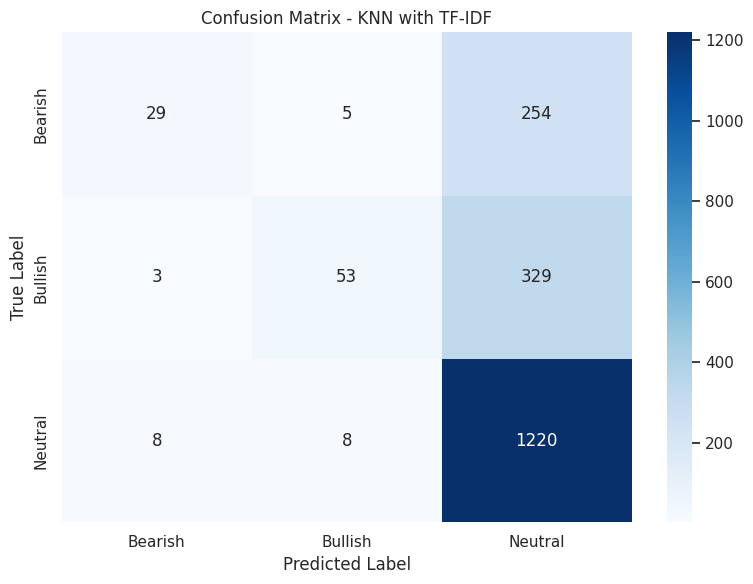

In [ ]:
# Cell 40: Train KNN model with TF-IDF features
print("Training KNN model with TF-IDF features...")
knn_tfidf = KNeighborsClassifier(n_neighbors=5)
knn_tfidf.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_tfidf = knn_tfidf.predict(X_val_tfidf)
print("\nKNN with TF-IDF - Evaluation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_tfidf):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_tfidf))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred_tfidf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Bearish', 'Bullish', 'Neutral'],
           yticklabels=['Bearish', 'Bullish', 'Neutral'])
plt.title('Confusion Matrix - KNN with TF-IDF')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7bf3fdfafba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error
Exception ignored on calling ctypes callback function: <functio

Training KNN model with Word2Vec features...

KNN with Word2Vec - Evaluation Metrics:
Accuracy: 0.6595

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.26      0.29       288
           1       0.46      0.40      0.43       385
           2       0.77      0.83      0.80      1236

    accuracy                           0.66      1909
   macro avg       0.52      0.50      0.51      1909
weighted avg       0.64      0.66      0.65      1909



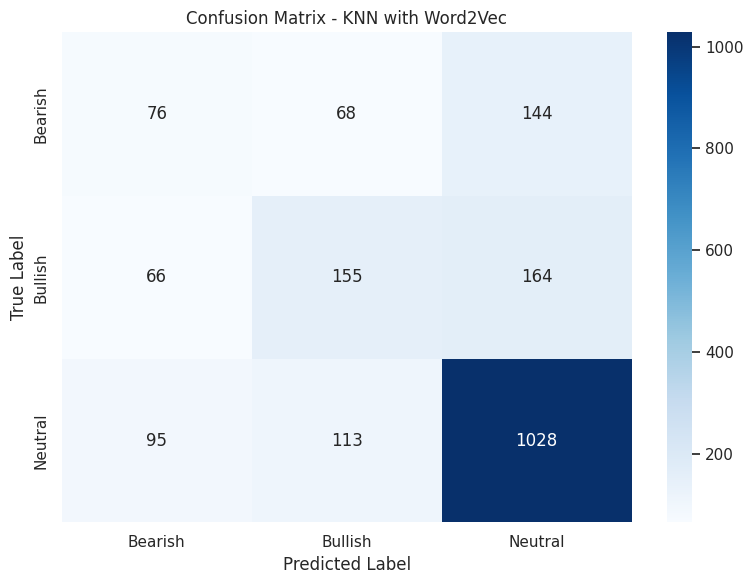

In [ ]:
# Cell 41: Train KNN model with Word2Vec features
print("Training KNN model with Word2Vec features...")
knn_w2v = KNeighborsClassifier(n_neighbors=5)
knn_w2v.fit(X_train_w2v, y_train)

# Predict and evaluate
y_pred_w2v = knn_w2v.predict(X_val_w2v)
print("\nKNN with Word2Vec - Evaluation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_w2v):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_w2v))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred_w2v)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Bearish', 'Bullish', 'Neutral'],
           yticklabels=['Bearish', 'Bullish', 'Neutral'])
plt.title('Confusion Matrix - KNN with Word2Vec')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

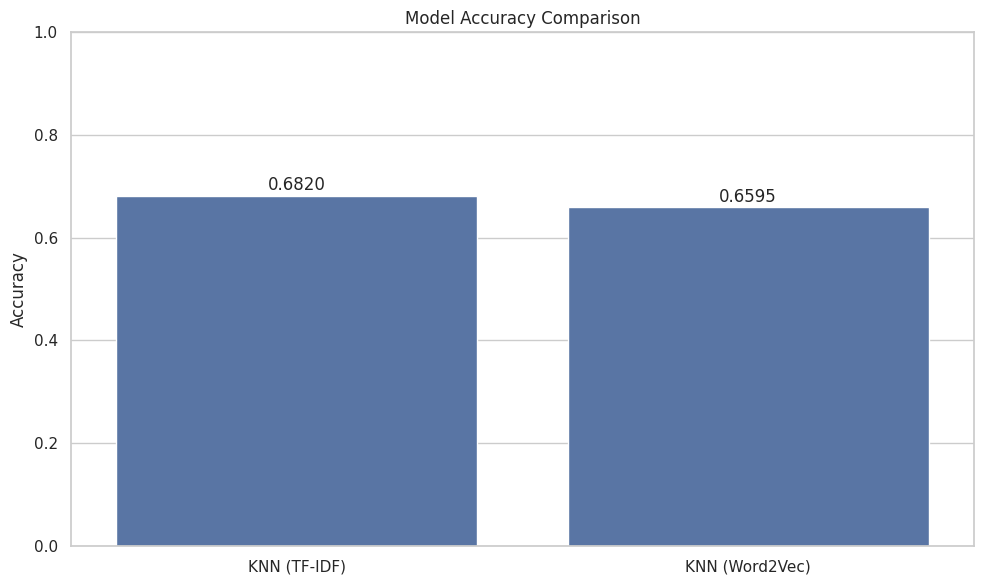

In [ ]:
# Cell 42: Compare model performances
models = ['KNN (TF-IDF)', 'KNN (Word2Vec)']
accuracies = [
    accuracy_score(y_val, y_pred_tfidf),
    accuracy_score(y_val, y_pred_w2v)
]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.6312 - loss: 0.8927 - val_accuracy: 0.6998 - val_loss: 0.7155
Epoch 2/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.7437 - loss: 0.6058 - val_accuracy: 0.7800 - val_loss: 0.5919
Epoch 3/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.8483 - loss: 0.4058 - val_accuracy: 0.7936 - val_loss: 0.5985
Epoch 4/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.8913 - loss: 0.2949 - val_accuracy: 0.7873 - val_loss: 0.6483
Epoch 5/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.9221 - loss: 0.2173 - val_accuracy: 0.7816 - val_loss: 0.7350


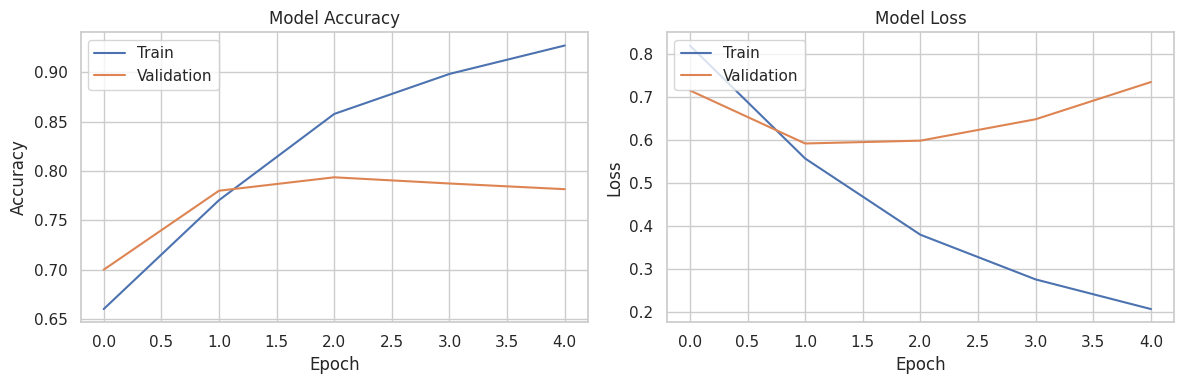

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

LSTM Model - Evaluation Metrics:
Accuracy: 0.7816

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.54      0.56       288
           1       0.71      0.64      0.67       385
           2       0.84      0.88      0.86      1236

    accuracy                           0.78      1909
   macro avg       0.71      0.69      0.70      1909
weighted avg       0.78      0.78      0.78      1909



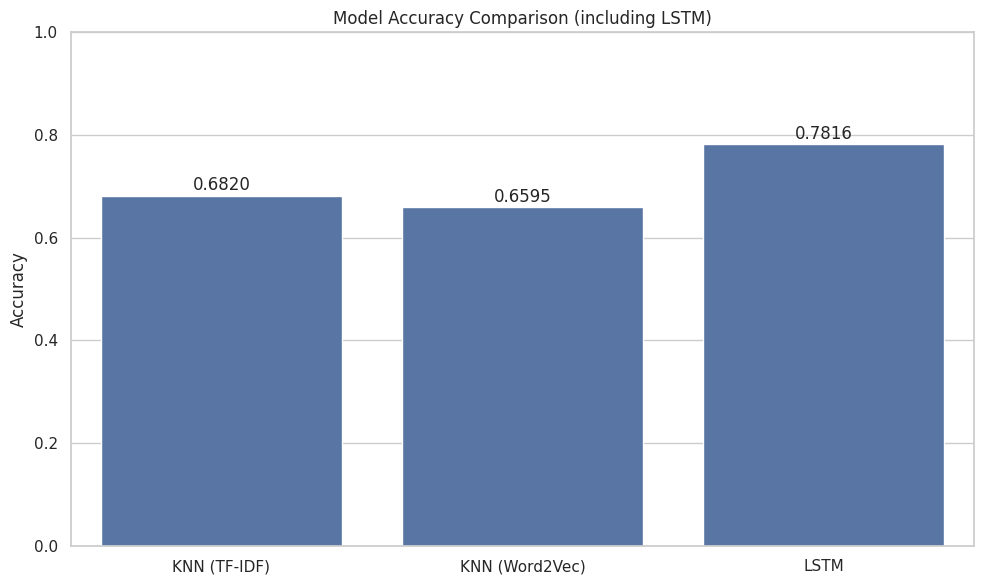

In [ ]:
# Cell 44: LSTM implementation (optional)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D

# Set random seed for reproducibility
tf.random.set_seed(42)

# Tokenize text
max_words = 5000  # Max vocabulary size
max_len = 50      # Max sequence length
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

# Convert labels to categorical
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=3)

# Build LSTM model
model = Sequential()
model.add(Embedding(max_words, 100, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=5,
    batch_size=64,
    validation_data=(X_val_pad, y_val_cat),
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

# Evaluate LSTM model
y_pred_prob = model.predict(X_val_pad)
y_pred_lstm = np.argmax(y_pred_prob, axis=1)

print("\nLSTM Model - Evaluation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_lstm):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_lstm))

# Add LSTM to model comparison
models.append('LSTM')
accuracies.append(accuracy_score(y_val, y_pred_lstm))

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison (including LSTM)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.show()

In [ ]:
# Cell 45: Load test data and make predictions with best model
# Determine which model performed best on validation data
print("Loading test data...")
try:
    test_data = pd.read_csv('/content/test.csv')
    print(f"Test data loaded: {test_data.shape} rows")
except FileNotFoundError:
    print("Test data file not found. Please upload the 'test.csv' file.")
    from google.colab import files
    uploaded = files.upload()
    test_data = pd.read_csv('test.csv')

# Preprocess test data
print("Preprocessing test data...")
test_data['cleaned_text'] = test_data['text'].apply(clean_text)
test_data['text_no_stopwords'] = test_data['cleaned_text'].apply(remove_stopwords)
test_data['lemmatized_text'] = test_data['text_no_stopwords'].apply(lemmatize_text)

# Choose the best model for predictions (based on validation results)
# For this example, let's assume TF-IDF with KNN performed best
print("Making predictions with best model...")
X_test_tfidf = tfidf_vectorizer.transform(test_data['lemmatized_text'])
predictions = knn_tfidf.predict(X_test_tfidf)

# Create submission file
submission = pd.DataFrame({
    'id': test_data['id'],
    'label': predictions
})

submission_file = 'pred_XX.csv'  # Replace XX with your group number
submission.to_csv(submission_file, index=False)
print(f"Predictions saved to {submission_file}")

# If in Colab, provide download link
try:
    from google.colab import files
    files.download(submission_file)
    print(f"Download initiated for {submission_file}")
except:
    print(f"File saved locally to {submission_file}")

Loading test data...
Test data file not found. Please upload the 'test.csv' file.


KeyboardInterrupt: 

In [ ]:
# Cell 46: Summary and conclusions
print("""
Project Summary:
---------------
1. Preprocessing:
   - Cleaned text (removed URLs, special characters, etc.)
   - Removed stopwords
   - Applied lemmatization

2. Feature Engineering:
   - Bag of Words (BoW)
   - TF-IDF
   - Word2Vec

3. Models Trained:
   - KNN with TF-IDF
   - KNN with Word2Vec
   - [Optional] LSTM

4. Best Performing Model:
   [Fill in based on your results]

Future Work:
-----------
1. Fine-tune hyperparameters (e.g., k in KNN, LSTM architecture)
2. Try more advanced transformer models like BERT
3. Experiment with ensemble methods
4. Implement additional preprocessing techniques

The predictions are saved in 'pred_XX.csv' and ready for submission.
""")